## Importing Libraries

In [3]:
import os
import math
import cv2
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import h5py
from keras import layers
from lrfinder import LRFinder
from PIL import Image, ImageOps
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [2]:
!pip install tensorflow-hub
!git clone https://github.com/beringresearch/lrfinder/
!cd lrfinder && python3 -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'lrfinder'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 54 (delta 12), reused 52 (delta 10), pack-reused 0
Unpacking objects: 100% (54/54), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/lrfinder
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for lrfinder: filename=lrfinder-0.1-py3-none-any.whl size=2486 sha256=6042d2d3073b0594e85feb24c1

In [ ]:
pip install lrfinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import seaborn as sns
from skimage import io

In [5]:
from tensorflow.keras.applications.resnet import ResNet50

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout

In [7]:
from tensorflow.keras.models import load_model

In [8]:
import h5py
print(h5py.__version__)

3.1.0


## Data Preprocessing 

### Data Augmentation

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
input_size = (160,160)
batch_size = 64

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Split/augmented_train',
                                                 target_size = input_size,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Split/augmented_validation',
                                            target_size = input_size,
                                            batch_size = batch_size,
                                            class_mode = 'categorical')


Found 1788 images belonging to 19 classes.
Found 1575 images belonging to 19 classes.


## FaceNet Model

In [14]:
model = load_model('/content/drive/MyDrive/facenet_keras.h5')

print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


In [15]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

In [16]:
set_trainable = False
for layer in model.layers:
    if layer.name[:6] == 'Block8':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
new_model = Sequential()
new_model.add(model)
new_model.add(Dropout(0.5))
new_model.add(Dense(19,activation='sigmoid'))

In [18]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v1 (Functi  (None, 128)              22808144  
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 19)                2451      
                                                                 
Total params: 22,810,595
Trainable params: 9,831,955
Non-trainable params: 12,978,640
_________________________________________________________________


In [19]:
from tensorflow.keras.optimizers import Adam

new_model.compile(optimizer = Adam(0.00075), 
              loss ="categorical_crossentropy", 
              metrics =["categorical_accuracy"])


In [20]:
history = new_model.fit(training_set, epochs = 30, validation_data = test_set)

Epoch 1/30
28/28 [==============================] - 949s 34s/step - loss: 1.7220 - categorical_accuracy: 0.5263 - val_loss: 1.6052 - val_categorical_accuracy: 0.5346
Epoch 2/30
28/28 [==============================] - 6s 231ms/step - loss: 0.3360 - categorical_accuracy: 0.9105 - val_loss: 1.4555 - val_categorical_accuracy: 0.5708
Epoch 3/30
28/28 [==============================] - 7s 267ms/step - loss: 0.0956 - categorical_accuracy: 0.9799 - val_loss: 1.0495 - val_categorical_accuracy: 0.7371
Epoch 4/30
28/28 [==============================] - 6s 229ms/step - loss: 0.0595 - categorical_accuracy: 0.9883 - val_loss: 0.7888 - val_categorical_accuracy: 0.7994
Epoch 5/30
28/28 [==============================] - 6s 226ms/step - loss: 0.0344 - categorical_accuracy: 0.9950 - val_loss: 0.6019 - val_categorical_accuracy: 0.8565
Epoch 6/30
28/28 [==============================] - 6s 228ms/step - loss: 0.0180 - categorical_accuracy: 0.9978 - val_loss: 0.4359 - val_categorical_accuracy: 0.8940
Epoc

In [21]:
new_model.save("/content/drive/MyDrive/facenet_2.h5")

In [22]:
best_train_accuracy = history.history['categorical_accuracy'][np.argmin(history.history['loss'])]
best_train_accuracy

1.0

In [23]:
max(history.history['categorical_accuracy'])

1.0

In [24]:
best_test_accuracy = history.history['val_categorical_accuracy'][np.argmin(history.history['val_loss'])]
best_test_accuracy

0.9873015880584717

In [25]:
max(history.history['val_categorical_accuracy'])

0.9873015880584717

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/Plots/facenet_models1.png', show_shapes=True, show_layer_names=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.937996 to fit
tcmalloc: large alloc 1696546816 bytes == 0x5626d2f8e000 @  0x7fe7cf653001 0x7fe7cb8ea1fa 0x7fe7cb8ea2ad 0x7fe7cca756df 0x7fe7ccf6c261 0x7fe7cf3e9468 0x7fe7cf3ebd53 0x5626d1074092 0x7fe7ced9ec87 0x5626d107412a



In [ ]:
pip install tensorflow.keras.utils

In [ ]:
pip install tensorflow

Text(0.5, 1.0, 'Loss Curves')

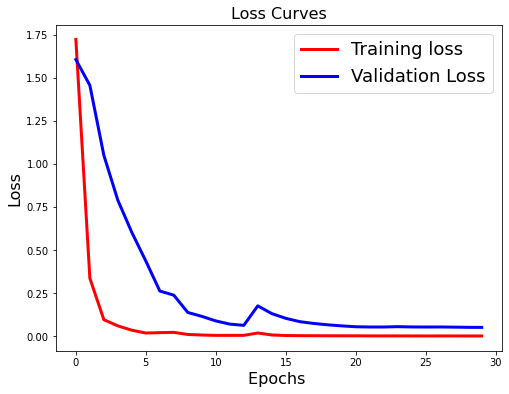

In [27]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

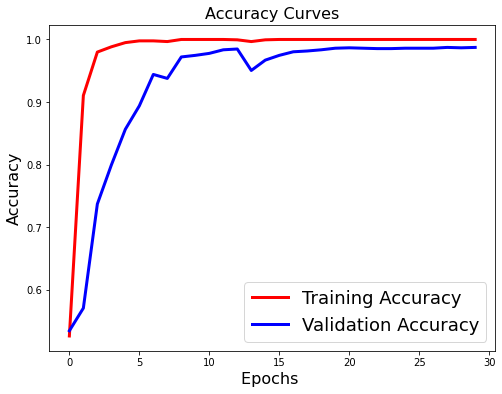

In [28]:
plt.figure(figsize=[8,6])
plt.plot(history.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)